In [94]:
import numpy as np 
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.listdir("../input"))

from matplotlib import colors
from matplotlib.colors import ListedColormap

['en.openfoodfacts.org.products.tsv']


In [95]:
import timeit
from datetime import datetime

##Feature Processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

In [96]:
data = pd.read_csv("../input/en.openfoodfacts.org.products.tsv", sep="\t", nrows=100000)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (19,20,24,25,26,28,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.



## Peek at the data


In [97]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,...,NaN,0.0214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,NaN,NaN,NaN,...,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.143,NaN,0.00514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,NaN,NaN,Bob's Red Mill,bob-s-red-mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,Organic polenta,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Take-Away

* A bunch of nan-values are present. Thus not all information seem to be useful to use for machine learning tasks. Or perhaps only for some groups in the data some columns with lot of nans may be useful. 
* Some features seem to be more informative than others. For example in the creator-feature the value "openfoodfacts-contributors" is too general and in the ingredients-feature there is a lot additional information we can extract and work with.

I like to dive through the EDA in a question-based manner. I hope we can find some interesting patterns to work with later on ;-) .  

Handling null values

In [98]:
null_percentage = data.isnull().mean() * 100

print(null_percentage)

code                                      0.000
url                                       0.000
creator                                   0.000
created_t                                 0.000
created_datetime                          0.000
last_modified_t                           0.000
last_modified_datetime                    0.000
product_name                              0.877
generic_name                             99.160
quantity                                 96.998
packaging                                98.241
packaging_tags                           98.241
brands                                    1.774
brands_tags                               1.774
categories                               97.155
categories_tags                          97.155
categories_en                            97.155
origins                                  99.649
origins_tags                             99.650
manufacturing_places                     99.350
manufacturing_places_tags               

In [99]:
#Removing columns with more than 50 %

cols_to_drop = null_percentage[null_percentage > 50].index

# Drop those columns
df = data.drop(columns=cols_to_drop)

In [100]:
# Output the result
print("Dropped columns:", list(cols_to_drop))

Dropped columns: ['generic_name', 'quantity', 'packaging', 'packaging_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_en', 'image_url', 'image_small_url', 'energy-from-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-a

## Zero nan features

Which feature columns are always without nan values?

In [101]:
full_col = null_percentage[null_percentage == 0].index
full_col

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'states', 'states_tags',
       'states_en'],
      dtype='object')

What does the states_en and states_tags features mean? 

In [102]:
example = data.loc[0,full_col]
print(example["states_tags"])
print(example["states_en"])

en:to-be-completed,en:nutrition-facts-to-be-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:characteristics-to-be-completed,en:categories-to-be-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-completed,en:product-name-completed,en:photos-to-be-validated,en:photos-uploaded
To be completed,Nutrition facts to be completed,Ingredients to be completed,Expiration date to be completed,Characteristics to be completed,Categories to be completed,Brands completed,Packaging to be completed,Quantity completed,Product name completed,Photos to be validated,Photos uploaded


There are many columns with almost full values (methods to make them 100)

In [103]:
null_percentagex = df.isnull().mean() * 100

print(null_percentagex)

code                                        0.000
url                                         0.000
creator                                     0.000
created_t                                   0.000
created_datetime                            0.000
last_modified_t                             0.000
last_modified_datetime                      0.000
product_name                                0.877
brands                                      1.774
brands_tags                                 1.774
countries                                   0.029
countries_tags                              0.029
countries_en                                0.029
ingredients_text                            2.884
serving_size                                3.449
additives_n                                 2.884
additives                                   2.888
additives_tags                             32.281
additives_en                               32.281
ingredients_from_palm_oil_n                 2.884


The data, which is available for download in different formats, contains detailed information on multiple product dimensions, including textual and image information (see an example here).

In this EDA exercise, your objective is to explore the data, obtain useful statistics and identify the data required to allow an ML model to extract the information in a product’s nutritional table using product images as the input. This step will be focused on data analysis and does not involve any model development.

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
code                                       100000 non-null int64
url                                        100000 non-null object
creator                                    100000 non-null object
created_t                                  100000 non-null int64
created_datetime                           100000 non-null object
last_modified_t                            100000 non-null int64
last_modified_datetime                     100000 non-null object
product_name                               99123 non-null object
brands                                     98226 non-null object
brands_tags                                98226 non-null object
countries                                  99971 non-null object
countries_tags                             99971 non-null object
countries_en                               99971 non-null object
ingredients_text                         

In [105]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,countries,countries_tags,countries_en,ingredients_text,serving_size,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states,states_tags,states_en,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,NaN,0.0,0.0,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,Torn & Glasser,torn-glasser,US,en:united-states,United States,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,NaN,0.0,0.0,b,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,Grizzlies,grizzlies,US,en:united-states,United States,"Organic hazelnuts, organic cashews, organic wa...",28 g (0.25 cup),0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,NaN,0.0,0.0,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",2540.0,57.14,5.36,NaN,NaN,17.86,3.57,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,Bob's Red Mill,bob-s-red-mill,US,en:united-states,United States,Organic polenta,35 g (0.25 cup),0.0,[ organic-polenta -> en:organic-polenta ] [...,NaN,NaN,0.0,0.0,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",1552.0,1.43,NaN,NaN,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Removing columns that look unnecessary. Like countries that have three columns that retain the same information.

In [106]:
drop_cols = [
    "countries", "countries_tags",
    "additives", "additives_tags",
    "states", "states_tags",
    "brands_tags"]

df = df.drop(columns=drop_cols)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
code                                       100000 non-null int64
url                                        100000 non-null object
creator                                    100000 non-null object
created_t                                  100000 non-null int64
created_datetime                           100000 non-null object
last_modified_t                            100000 non-null int64
last_modified_datetime                     100000 non-null object
product_name                               99123 non-null object
brands                                     98226 non-null object
countries_en                               99971 non-null object
ingredients_text                           97116 non-null object
serving_size                               96551 non-null object
additives_n                                97116 non-null float64
additives_en                            

In [108]:
df['created_datetime'] = pd.to_datetime(df['created_datetime'])
df['last_modified_datetime'] = pd.to_datetime(df['last_modified_datetime'])


In [109]:
cat_cols = ['brands', 'countries_en', 'nutrition_grade_fr', 'states_en']
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())
    print('=====================')


brands: 11929 unique values
Kroger         1635
Roundy's       1280
Spartan        1209
Great Value    1184
Weis           1019
Name: brands, dtype: int64
countries_en: 140 unique values
United States            96547
France                    1350
Canada                     665
United Kingdom             479
France,United Kingdom      219
Name: countries_en, dtype: int64
nutrition_grade_fr: 5 unique values
d    22626
e    15597
c    15359
a    12723
b    12184
Name: nutrition_grade_fr, dtype: int64
states_en: 366 unique values
To be completed,Nutrition facts completed,Ingredients completed,Expiration date to be completed,Packaging-code-to-be-completed,Characteristics to be completed,Categories to be completed,Brands completed,Packaging to be completed,Quantity to be completed,Product name completed,Photos to be uploaded              93449
To be completed,Nutrition facts completed,Ingredients completed,Expiration date to be completed,Packaging-code-to-be-completed,Characteristics to be

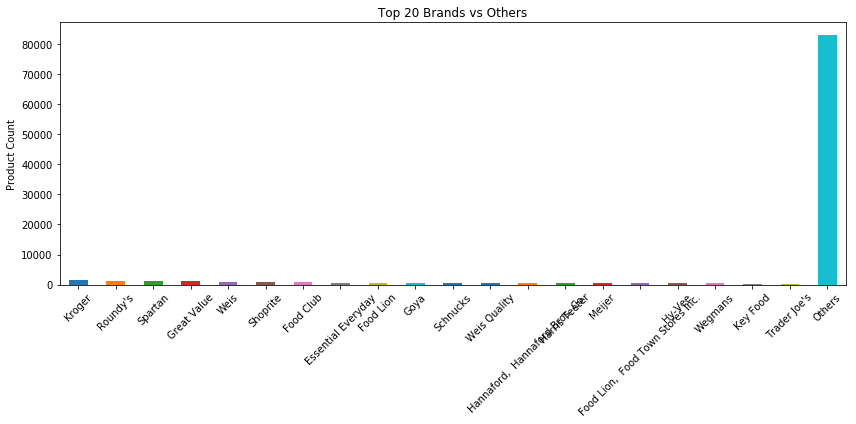

In [110]:
top_brands = df['brands'].value_counts().nlargest(20)
other_count = df['brands'].value_counts().iloc[20:].sum()

brand_plot_data = top_brands.append(pd.Series({'Others': other_count}))

plt.figure(figsize=(12, 6))
brand_plot_data.plot(kind='bar')
plt.title('Top 20 Brands vs Others')
plt.ylabel('Product Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


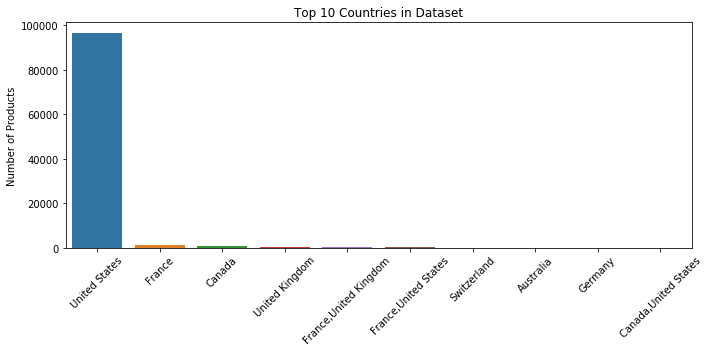

In [111]:
top_countries = df['countries_en'].value_counts().nlargest(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 10 Countries in Dataset')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

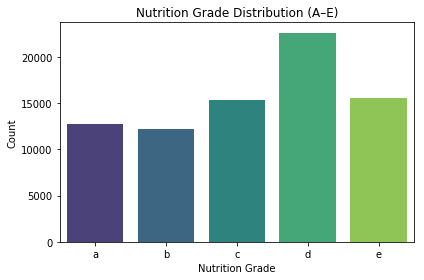

In [112]:
grade_counts = df['nutrition_grade_fr'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=grade_counts.index, y=grade_counts.values, palette='viridis')
plt.title('Nutrition Grade Distribution (A–E)')
plt.xlabel('Nutrition Grade')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


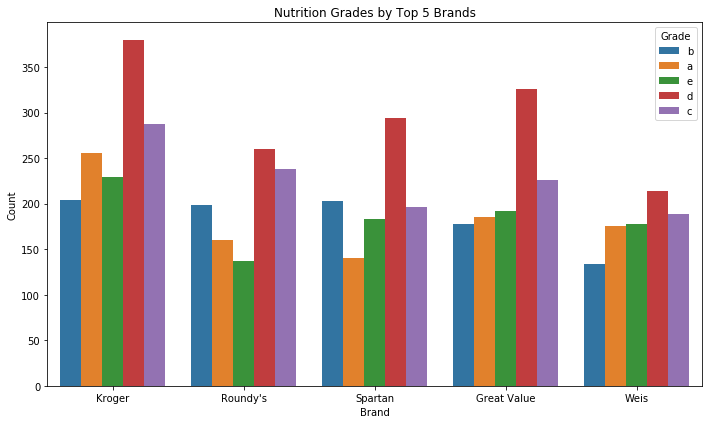

In [113]:
top5_brands = ['Kroger', "Roundy's", 'Spartan', 'Great Value', 'Weis']
df_top5 = df[df['brands'].isin(top5_brands)]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_top5, x='brands', hue='nutrition_grade_fr', order=top5_brands)
plt.title('Nutrition Grades by Top 5 Brands')
plt.ylabel('Count')
plt.xlabel('Brand')
plt.legend(title='Grade')
plt.tight_layout()
plt.show()


In [114]:
features_to_check = ['Nutrition facts completed', 'Ingredients completed',
                     'Photos uploaded', 'Product name completed']


for feature in features_to_check:
    col_name = feature.lower().replace(' ', '_').replace('-', '_')
    df[col_name] = df['states_en'].str.contains(feature)

print(df['nutrition_facts_completed'].value_counts())


True     97679
False     2321
Name: nutrition_facts_completed, dtype: int64


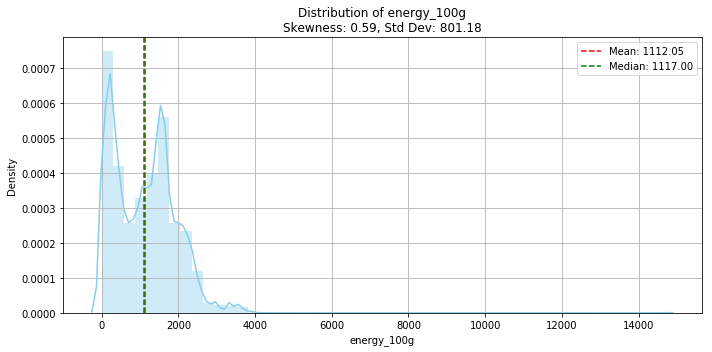

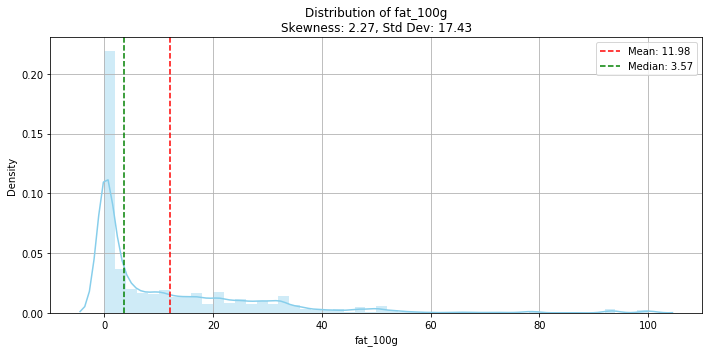

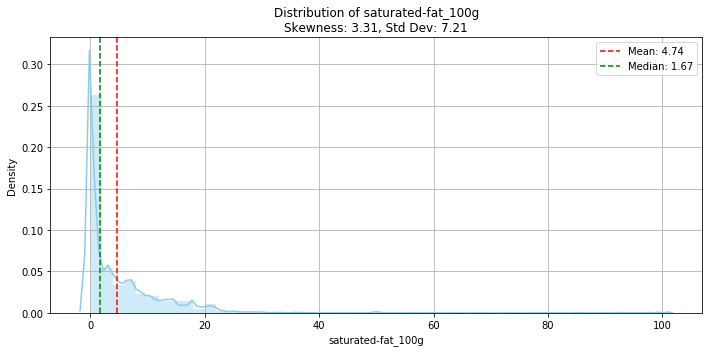

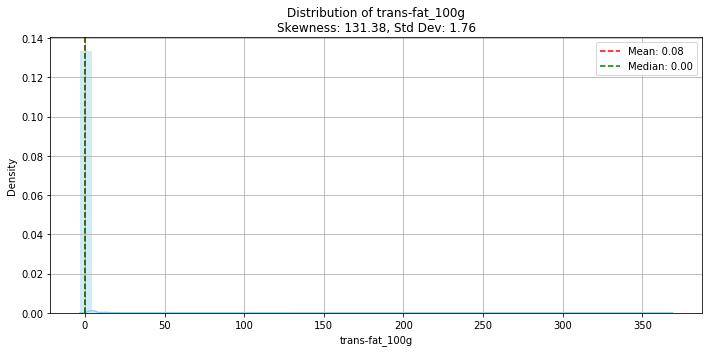

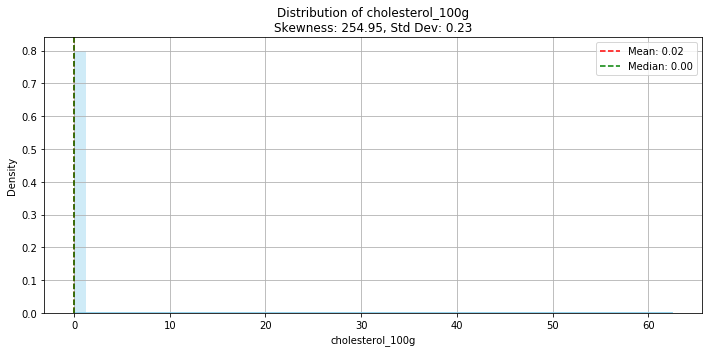

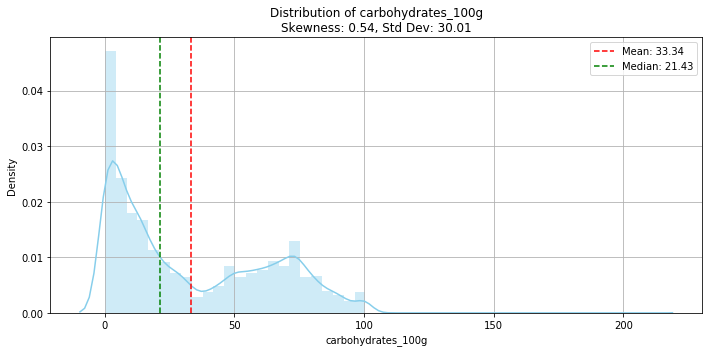

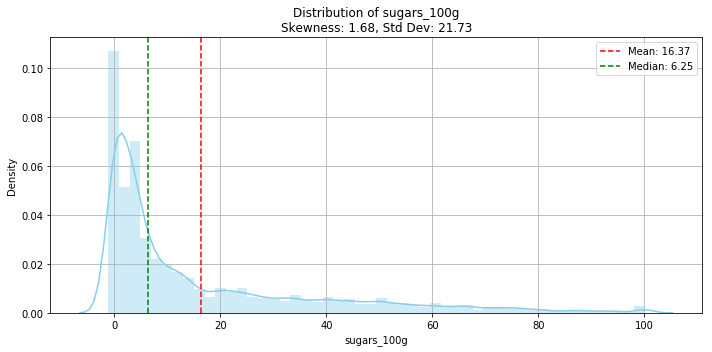

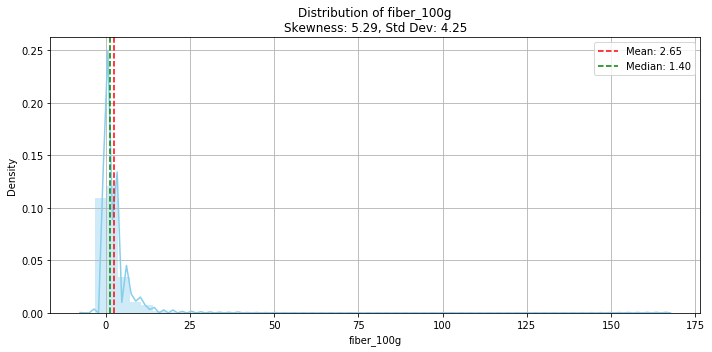

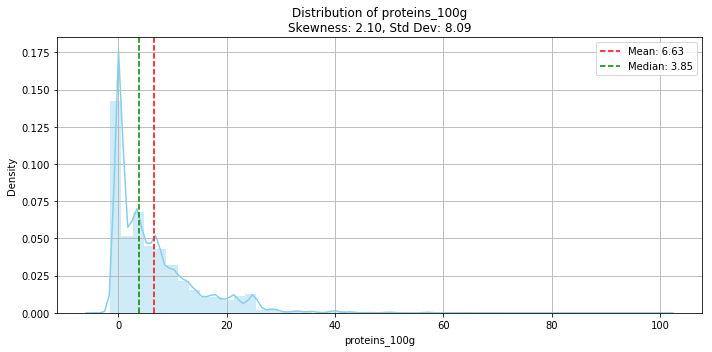

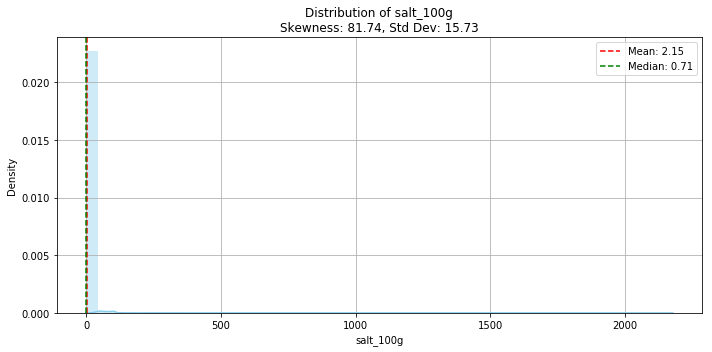

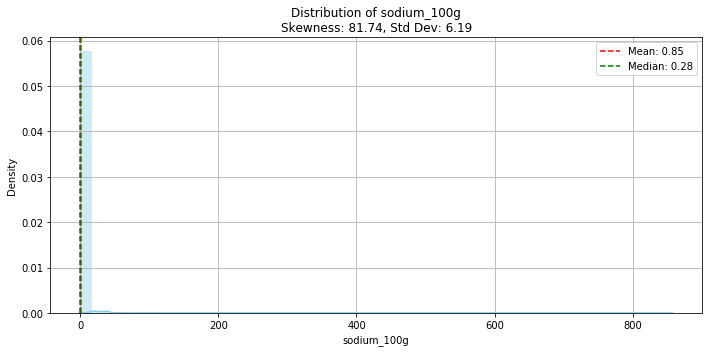

In [115]:

for col in nutrients:
    plt.figure(figsize=(10, 5))

    # Drop NaNs
    data = df[col].dropna()

    # Compute and print stats
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    skewness = data.skew()

    # Plot histogram with KDE
    sns.distplot(data, bins=50, kde=True, color='skyblue')
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    plt.title(f'Distribution of {col}\nSkewness: {skewness:.2f}, Std Dev: {std_val:.2f}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


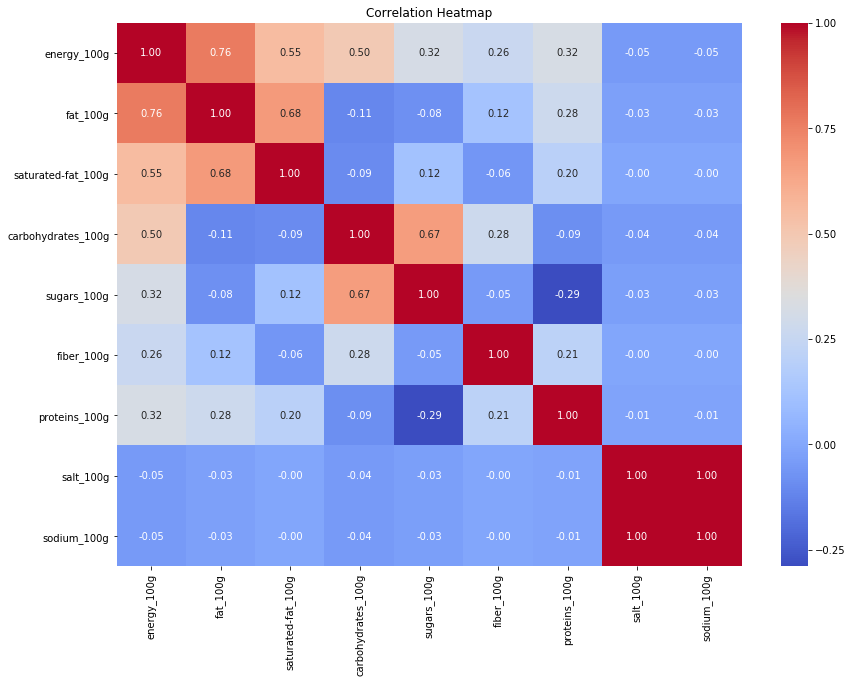

In [116]:
plt.figure(figsize=(14,10))
corr = df[[
    'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g'
]].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Based on the correlation table, sodium and salt are exactly same (one can be removed).

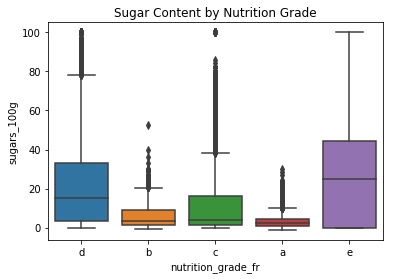

In [117]:
sns.boxplot(x='nutrition_grade_fr', y='sugars_100g', data=df)
plt.title("Sugar Content by Nutrition Grade")
plt.show()


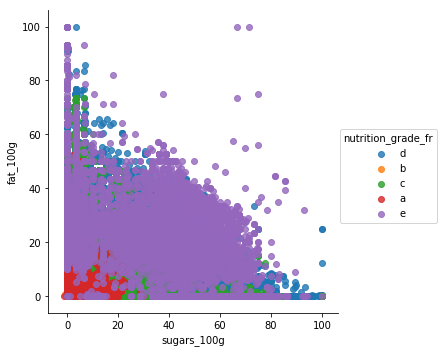

In [118]:
sns.lmplot(data=df, x='sugars_100g', y='fat_100g', hue='nutrition_grade_fr', fit_reg=False)


In [119]:
df[['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']].describe()


,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n
count,97116.000000,97116.000000
mean,0.000875,0.031673
std,0.029572,0.177930
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,3.000000


Removing Outliers

In [120]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(numeric_cols)


['code', 'created_t', 'last_modified_t', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']


In [121]:
def replace_outliers_with_nan(df, columns):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_cleaned[col] = df_cleaned[col].where((df_cleaned[col] >= lower) & (df_cleaned[col] <= upper), np.nan)
    return df_cleaned

df_iqr_nan = replace_outliers_with_nan(df, numeric_cols)
print(df_iqr_nan.shape)


(100000, 39)
